IMPORTING NECESSARY LIBRARIES

In [1]:
import keras
from keras.layers import Dense,Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten,Concatenate,Input,Lambda
from keras.models import Sequential
import tensorflow as tf
import numpy as np 
import random
import matplotlib.pyplot as plt
from keras.models import Model
from keras import backend as K
import numpy as np
import glob
from sklearn.preprocessing import LabelBinarizer
import cv2
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt
from itertools import permutations
import seaborn as sns
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import pydot
from keras.utils import plot_model

Using TensorFlow backend.


In [9]:
# 1. CALCULATING DISTANCE MATRICS USING Eucledian Distance Function.
# 2. CALCULATING THE LOSS USING contrastive loss Function.

#Eucledian Distance Function  #Imported From Keras Documentation 
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# 1. LOADING THE DATASET AND PREFORMIMG DATA AUGMENTATION

train_dir='D:/SIAMESE/TransferLearning-on-Siamese-Branches-master/dataset/training_data'
test_dir='D:/SIAMESE/TransferLearning-on-Siamese-Branches-master/dataset/validation_data'
from keras.preprocessing.image import ImageDataGenerator
train_gen=ImageDataGenerator(rescale=1/255)
test_gen=ImageDataGenerator(rescale=1/255)
train_generator=train_gen.flow_from_directory(train_dir,target_size=(224,224),class_mode='binary')
test_generator=test_gen.flow_from_directory(test_dir,class_mode='binary',target_size=(224,224))
IMG_shape=(224,224,3)

# DIFFERENT TRANSFER LEARNING MODELS
# LOADING A PRE-TRAINED MODEL

#vgg=tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(200,200,3))
#vgg19=tf.keras.applications.vgg19.VGG19(include_top=False,input_shape=(200,200,3))
#mobilenet=tf.keras.applications.MobileNetV2(include_top=False,input_shape=(200,200,3))
inception=keras.applications.InceptionV3(include_top=False,input_shape=(224, 224,3))

x=inception.layers[-3].output
global_avg=keras.layers.GlobalAveragePooling2D()(x)
prediction_layer=keras.layers.Dense(1,activation='sigmoid')(global_avg)

model=keras.models.Model(inception.input,prediction_layer)
model.summary()
#plot_model(model, show_shape, show_layer_name, to_file='siamese_inception.png')
plot_model(model, to_file="siamese_inception.png", show_shapes=True, show_layer_names=True)

for layers in model.layers[:-50]:
    layers.trainable=False
input1=Input((224,224,3))
input2=Input((224,224,3))
M1=model(input1)
M2=model(input2)


merged=keras.layers.Lambda(euclidean_distance)([M1,M2])
DL=keras.layers.Dense(1,activation='sigmoid')(merged)

#plot_model(merged, to_file='siamese_inception_merged.png')
#plot_model(DL, to_file='siamese_inception_DL.png')

#DL.summary()


#model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),loss=contrastive_loss,metrics=[accuracy])
#model.fit_generator(test_generator,epochs=100,validation_data=train_generator)


# MERGING THE BRANCHED NETWORK AND ADDING A FINAL LAYER

#input=Input((224,224,3))                                               ###
#x=keras.layers.Conv2D(5,(1,1),strides=1,padding='same',activation='relu')(input) 
#x=keras.layers.BatchNormalization()(x)     ####
#x=keras.layers.MaxPool2D(pool_size=(2,2))(x)                         #####
#x=keras.layers.Flatten()(x)                                            #####
#dense=keras.layers.Dense(500,activation='relu')(x)
#dense=keras.layers.Dense(500,activation='relu')(dense)
#dense=keras.layers.Dense(5)(dense)                                        ##########
#model=keras.models.Model(input,dense)                         ################ Base Network TO be Shared ############


inpu1=Input((224,224,3))                                         #Sharing of Base Network
inpu2=Input((224,224,3))
md1=model(inpu1)
md2=model(inpu2)

merged=keras.layers.Lambda(euclidean_distance)([md1,md2])                   #Concatenating the two networks using the Lambda layer to combine with eucledian_distance
DL=keras.layers.Dense(1,activation='sigmoid')(merged)        #Adding a final layer       

FM=Model(inputs=[inpu1,inpu2],outputs=DL)

#plot_model(FM, to_file='siamese_inception_FM.png')




Found 1120 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_378 (Conv2D)             (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_378 (BatchN (None, 111, 111, 32) 96          conv2d_378[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 111, 111, 32) 0           batch_normalization_378[0][0]    
_________

In [10]:
model.compile(optimizer=Adam(0.0001, decay=2.5e-4), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='contrastive_loss', metrics=['accuracy'])
#History = model.fit_generator(test_generator,epochs=100,validation_data=train_generator)

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=1120//32,
    epochs=20,
    validation_data=test_generator,
    validation_steps=140//32,
    verbose=True)

Epoch 1/20
35/35 [==============================] - 11s 320ms/step - loss: 0.1656 - accuracy: 0.9277 - val_loss: 2.7799 - val_accuracy: 0.5312
Epoch 2/20
35/35 [==============================] - 4s 114ms/step - loss: 0.0288 - accuracy: 0.9884 - val_loss: 0.8334 - val_accuracy: 0.6759
Epoch 3/20
35/35 [==============================] - 4s 110ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.2844 - val_accuracy: 0.8704
Epoch 4/20
35/35 [==============================] - 4s 110ms/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0.5905 - val_accuracy: 0.7963
Epoch 5/20
35/35 [==============================] - 4s 107ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.3391 - val_accuracy: 0.9537
Epoch 6/20
35/35 [==============================] - 4s 109ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 0.3803 - val_accuracy: 0.8906
Epoch 7/20
35/35 [==============================] - 4s 111ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1944 - val_accuracy: 0.9167
Epoch

CALCULATING PERFORMANCE MATRICS USING ACCURACY

In [12]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

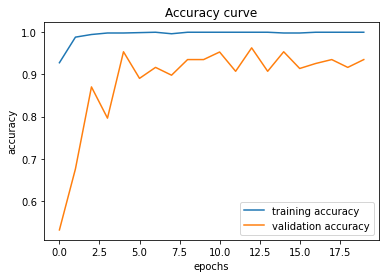

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

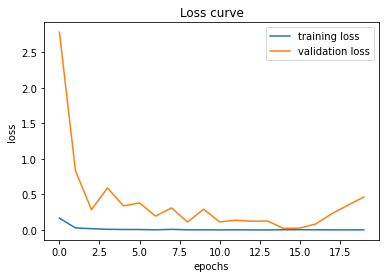

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()